# Consumer Complaint Classification – Transformers 

## Introduction  

The goal of this project is to develop a **text classification model** that categorizes **consumer complaints** into five financial categories using **transformer-based algorithms**.  

The dataset, obtained from the **Consumer Financial Protection Bureau (CFPB)**, contains **over 2 million consumer complaints** from **2011 to 2024**. Each complaint is a textual **narrative** describing a financial issue, and these complaints have been labeled into **five main categories**:  

- **Loans**  
- **Credit Reporting**  
- **Bank Accounts & Services**  
- **Debt Collection**  
- **Credit Card Services**  

---

## Data Understanding  

The dataset originates from the **Consumer Complaint Database** maintained by the **Consumer Financial Protection Bureau (CFPB)**, a **U.S. federal agency** that mediates disputes between financial institutions and consumers. Consumers submit complaints through an **online form**, detailing their financial issues.  

The dataset was **downloaded from the CFPB website** and underwent **preprocessing** to prepare it for NLP tasks. The key modifications include:  

- Retaining only records where a **"Consumer complaint narrative"** is available.  
- Reducing the dataset from **5,842,373** records to **2,023,066** entries.  
- Renaming the **"Consumer complaint narrative"** column to **"narrative"** for ease of coding.  
- Consolidating **18 original product categories** into **5 main categories (product_5)** to address overlaps in classification.  

---

## Consumer Complaint Classification Pipeline


In [4]:
# Install required packages
# !pip install transformers datasets pandas numpy scikit-learn torch tqdm

# --------------------
# Standard Libraries
# --------------------
import os
import re
import random

# --------------------
# Data Manipulation
# --------------------
import pandas as pd
import numpy as np

# --------------------
# Visualization
# --------------------
import matplotlib.pyplot as plt
import seaborn as sns


# --------------------
# Machine Learning
# --------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# --------------------
# PyTorch & Transformers
# --------------------
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    get_linear_schedule_with_warmup,
    RobertaTokenizer, 
    RobertaForSequenceClassification
)

# --------------------
# Progress Bar
# --------------------
from tqdm.auto import tqdm


# --------------------
# Pickle
# --------------------
import pickle
# --------------------
# Set Seed for Reproducibility
# --------------------
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(42)

# --------------------
# Device Configuration
# --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [5]:
# Load the data
df = pd.read_csv('data/complaints.csv')
df.head()

,Unnamed: 0,product_5,narrative,Product,Date received,Sub-product,Issue,Sub-issue,Company,State,Timely response?
0,234,Credit Reporting,Dear Possible Financial Inc you guyss aree rep...,Credit reporting or other personal consumer re...,2024-07-27,Credit reporting,Incorrect information on your report,Account information incorrect,Possible Financial Inc,MI,Yes
1,240,Debt Collection,"XXXX XXXX XXXX ( debt collector ), sent my boy...",Debt collection,2024-07-27,I do not know,Threatened to contact someone or share informa...,Talked to a third-party about your debt,BlueChip Financial,TX,Yes
2,257,Credit Reporting,I been receiving alerts my information was fou...,Credit reporting or other personal consumer re...,2024-07-23,Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,FC HoldCo LLC,SC,Yes
3,271,Credit Reporting,Subject : Dispute of Inaccurate Information on...,Credit reporting or other personal consumer re...,2024-07-27,Credit reporting,Improper use of your report,Reporting company used your report improperly,CORELOGIC INC,GA,Yes
4,276,Loans,They allowed me to use the account for about a...,"Payday loan, title loan, personal loan, or adv...",2024-07-26,Payday loan,Received a loan you didn't apply for,NaN,MoneyLion Inc.,PA,Yes


In [6]:
# Drop the 'Unnamed: 0' column
df = df.drop(columns=['Unnamed: 0'])

In [7]:
# Define sample size per category
sample_size = 10000

df_resampled = df.groupby("product_5").sample(n=sample_size, random_state=42)

df_resampled = df_resampled.reset_index(drop=True)

df_resampled["product_5"].value_counts()

product_5
Bank Accounts and Services    10000
Credit Card Services          10000
Credit Reporting              10000
Debt Collection               10000
Loans                         10000
Name: count, dtype: int64

In [8]:
# Encode the labels (LabelEncoder: str → int)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df_resampled['product_5'])

# Create label mapping (int → str) for interpretation later
label_mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))
reverse_label_mapping = {v: k for k, v in label_mapping.items()}  # Optional reverse

# Print the mapping for verification
print("\nLabel mapping (int → class name):")
for i, label in label_mapping.items():
    print(f"{i}: {label}")


Label mapping (int → class name):
0: Bank Accounts and Services
1: Credit Card Services
2: Credit Reporting
3: Debt Collection
4: Loans


In [9]:
# Split the data
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df_resampled['narrative'].values,
    encoded_labels,
    test_size=0.3,
    random_state=42,
    stratify=encoded_labels
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

print(f"\nTraining set size: {len(train_texts)}")
print(f"Validation set size: {len(val_texts)}")
print(f"Test set size: {len(test_texts)}")


Training set size: 35000
Validation set size: 7500
Test set size: 7500


Transformers settings

In [10]:
# === SELECT MODEL TYPE ===
robertA_base = False
robertA_base_large = False
distilbert = True  # Set the one you want to True

distilbert_save= True
robertA_base_save = False

# === AUTOMATIC CONFIG BASED ON FLAGS ===
if distilbert:
    model_name = 'distilbert-base-uncased'
    model_type = 'distilbert'
    batch_size = 16  # You can keep it higher for smaller models
    model_save_path = 'checkpoints_distilbert' if distilbert_save else None
    metric_save_path = 'metrics_distilbert'
elif robertA_base:
    model_name = 'roberta-base'
    model_type = 'roberta'
    batch_size = 16
    model_save_path= 'checkpoints_roberta' if robertA_base_save else None
    metric_save_path = 'metrics_roberta'
elif robertA_base_large:
    model_name = 'roberta-large'
    model_type = 'roberta'
    batch_size = 8  # roberta-large is heavy — lower the batch size
else:
    raise ValueError("Please set one of the model flags to True.")


In [11]:
# Create a custom dataset
class ConsumerComplaintDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        text = text.strip()

        # Tokenize the text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [12]:
if distilbert:
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
elif robertA_base:
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
elif robertA_base_large:
    tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
# Create datasets
train_dataset = ConsumerComplaintDataset(train_texts, train_labels, tokenizer)
val_dataset = ConsumerComplaintDataset(val_texts, val_labels, tokenizer)
test_dataset = ConsumerComplaintDataset(test_texts, test_labels, tokenizer)

batch_size = 16
# Create data loaders
if robertA_base_large:
    batch_size = 8

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [13]:
def train_model(model, train_dataloader, val_dataloader, epochs=4, learning_rate=5e-5, save_every_n_epochs=3, model_save_path="model"):
    # Prepare optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
    
    # Total number of training steps
    total_steps = len(train_dataloader) * epochs
    
    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=0, 
        num_training_steps=total_steps
    )
    
    # Lists to store loss and accuracy
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1s = []
    iteration_losses = []
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print('-' * 40)
        
        # Training
        model.train()
        total_train_loss = 0
        
        progress_bar = tqdm(train_dataloader, desc="Training")
        
        for batch in progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Clear previous gradients
            model.zero_grad()
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_train_loss += loss.item()
            iteration_losses.append(loss.item())
            # Backward pass
            loss.backward()
            
            # Clip the norm of the gradients to 1.0
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            # Update parameters and learning rate
            optimizer.step()
            scheduler.step()
            
            # Update progress bar
            progress_bar.set_postfix({'loss': loss.item()})
        
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        print(f"Average training loss: {avg_train_loss:.4f}")
        
        # Validation
        model.eval()
        total_val_loss = 0
        predictions = []
        true_labels = []
        
        for batch in tqdm(val_dataloader, desc="Validation"):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass without gradient calculation
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
            
            loss = outputs.loss
            total_val_loss += loss.item()
            
            # Get predictions
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            
            # Store predictions and true labels
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
        
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        
        val_accuracy = accuracy_score(true_labels, predictions)
        val_precision = precision_score(true_labels, predictions, average='weighted', zero_division=0)
        val_recall = recall_score(true_labels, predictions, average='weighted', zero_division=0)
        val_f1 = f1_score(true_labels, predictions, average='weighted', zero_division=0)
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        print(f"Validation Loss: {avg_val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f"Validation Precision: {val_precision:.4f}")
        print(f"Validation Recall: {val_recall:.4f}")
        print(f"Validation F1 Score: {val_f1:.4f}")
        print("\nClassification Report:")
        print(classification_report(true_labels, predictions))

        # === Save checkpoint every N epochs ===
        if (epoch + 1) % save_every_n_epochs == 0:
            checkpoint_dir = os.path.join(model_save_path, f"epoch_{epoch + 1}")
            os.makedirs(checkpoint_dir, exist_ok=True)
            model.save_pretrained(checkpoint_dir)
            try:
                model.config.tokenizer.save_pretrained(checkpoint_dir)  # If tokenizer is attached
            except:
                pass  # Or pass tokenizer separately outside
            print(f"Checkpoint saved to {checkpoint_dir}")
            '''
            metrics = {
        'epoch': epoch + 1,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'iteration_losses': iteration_losses,
        'val_precisions': val_precisions,
        'val_recalls': val_recalls,
        'val_f1s': val_f1s,
        }
    with open(os.path.join(metric_save_path, f"metric_epoch_{epoch + 1}"), 'wb') as f:
        pickle.dump(metrics, f)
        '''
    return model, train_losses, val_losses, val_accuracies,  iteration_losses, val_precisions, val_recalls, val_f1s

In [14]:
def plot_iteration_loss(iteration_losses):
    plt.figure(figsize=(10, 4))
    plt.plot(iteration_losses, label='Training Loss (per iteration)', linewidth=0.7)
    plt.title('Training Loss per Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Plotting Validation Accuracy, Precision, Recall and F1 Score for each Epoch

In [23]:
def plot_epoch_metrics(val_accuracies, val_precisions, val_recalls, val_f1s):
    epochs = list(range(1, len(val_accuracies) + 1))

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, val_accuracies, label='Accuracy')
    plt.plot(epochs, val_precisions, label='Precision')
    plt.plot(epochs, val_recalls, label='Recall')
    plt.plot(epochs, val_f1s, label='F1 Score')

    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Metrics per Epoch')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_epoch_metrics(val_accuracies, val_precisions, val_recalls, val_f1s):
    epochs = list(range(1, len(val_accuracies) + 1))

    # Accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, val_accuracies, label='Accuracy', color='blue', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy per Epoch')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Precision
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, val_precisions, label='Precision', color='green', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.title('Validation Precision per Epoch')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Recall
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, val_recalls, label='Recall', color='orange', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title('Validation Recall per Epoch')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # F1 Score
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, val_f1s, label='F1 Score', color='red', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score per Epoch')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [19]:
if model_type == 'distilbert':
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
    model = DistilBertForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label_mapping),
        output_attentions=False,
        output_hidden_states=False
    )
elif model_type == 'roberta':
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    model = RobertaForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label_mapping),
        output_attentions=False,
        output_hidden_states=False
    )

model = model.to(device)
# === Training parameters ===
epochs = 3
learning_rate = 5e-5

# === Train the model ===
model, train_losses, val_losses, val_accuracies, iteration_losses, val_precisions, val_recalls, val_f1s = train_model(
    model,
    train_dataloader,
    val_dataloader,
    epochs=epochs,
    learning_rate=learning_rate,
    save_every_n_epochs=3,
    model_save_path=model_save_path
)
'''
# === Save the model ===
# Convert model name (e.g., "distilbert-base-uncased") into a clean folder name
model_save_path = f"{model_name.replace('/', '_')}_consumer_complaints_model"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")
'''

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
----------------------------------------


Training:   0%|          | 0/2188 [00:00<?, ?it/s]

Average training loss: 0.5409


Validation:   0%|          | 0/469 [00:00<?, ?it/s]

Validation Loss: 0.4642
Validation Accuracy: 0.8491
Validation Precision: 0.8510
Validation Recall: 0.8491
Validation F1 Score: 0.8486

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      1500
           1       0.84      0.83      0.84      1500
           2       0.81      0.87      0.84      1500
           3       0.86      0.77      0.81      1500
           4       0.83      0.92      0.87      1500

    accuracy                           0.85      7500
   macro avg       0.85      0.85      0.85      7500
weighted avg       0.85      0.85      0.85      7500


Epoch 2/3
----------------------------------------


Training:   0%|          | 0/2188 [00:00<?, ?it/s]

Average training loss: 0.3517


Validation:   0%|          | 0/469 [00:00<?, ?it/s]

Validation Loss: 0.4276
Validation Accuracy: 0.8637
Validation Precision: 0.8646
Validation Recall: 0.8637
Validation F1 Score: 0.8639

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1500
           1       0.86      0.84      0.85      1500
           2       0.86      0.83      0.85      1500
           3       0.80      0.86      0.83      1500
           4       0.90      0.89      0.89      1500

    accuracy                           0.86      7500
   macro avg       0.86      0.86      0.86      7500
weighted avg       0.86      0.86      0.86      7500


Epoch 3/3
----------------------------------------


Training:   0%|          | 0/2188 [00:00<?, ?it/s]

Average training loss: 0.2318


Validation:   0%|          | 0/469 [00:00<?, ?it/s]

Validation Loss: 0.4955
Validation Accuracy: 0.8651
Validation Precision: 0.8649
Validation Recall: 0.8651
Validation F1 Score: 0.8649

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1500
           1       0.85      0.85      0.85      1500
           2       0.85      0.86      0.85      1500
           3       0.85      0.82      0.83      1500
           4       0.89      0.89      0.89      1500

    accuracy                           0.87      7500
   macro avg       0.86      0.87      0.86      7500
weighted avg       0.86      0.87      0.86      7500

Checkpoint saved to checkpoints_distilbert/epoch_3


'\n# === Save the model ===\n# Convert model name (e.g., "distilbert-base-uncased") into a clean folder name\nmodel_save_path = f"{model_name.replace(\'/\', \'_\')}_consumer_complaints_model"\nmodel.save_pretrained(model_save_path)\ntokenizer.save_pretrained(model_save_path)\nprint(f"Model saved to {model_save_path}")\n'

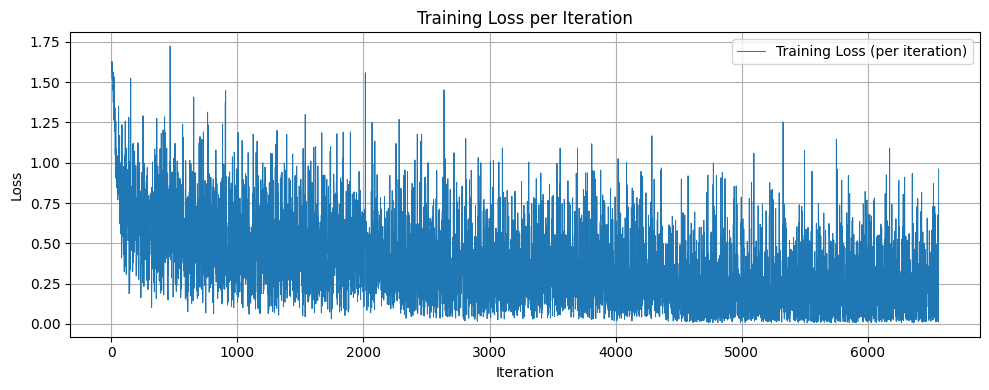

In [20]:
plot_iteration_loss(iteration_losses)

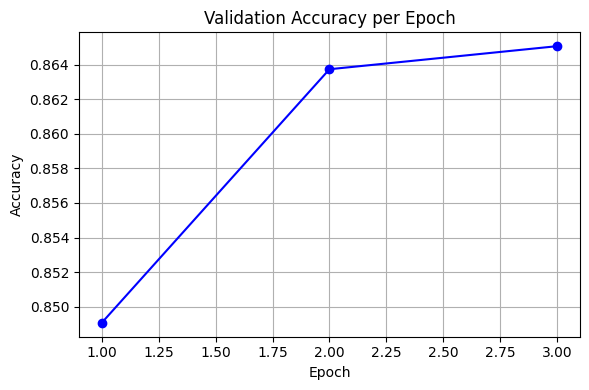

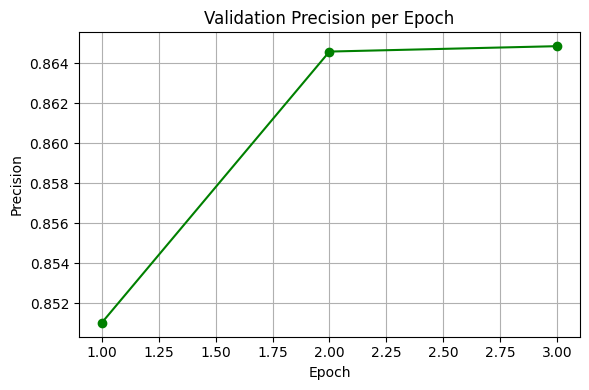

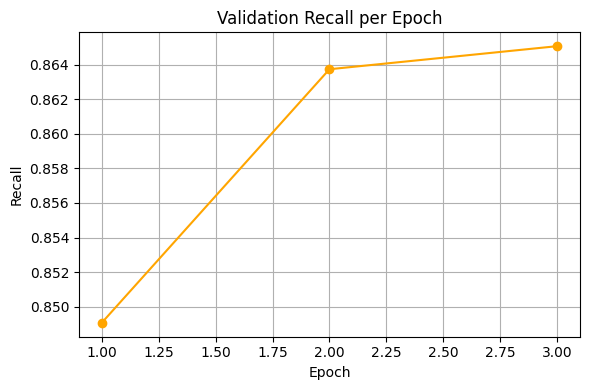

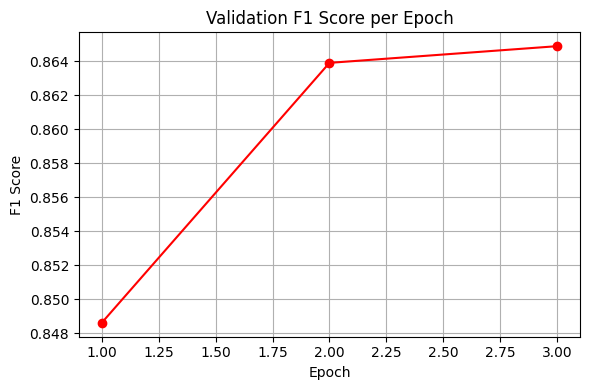

In [24]:
plot_epoch_metrics(val_accuracies, val_precisions, val_recalls, val_f1s)

Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

Test Accuracy: 0.8643
Test Precision: 0.8645
Test Recall: 0.8643
Test F1 Score: 0.8642

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1500
           1       0.84      0.84      0.84      1500
           2       0.84      0.87      0.85      1500
           3       0.86      0.82      0.84      1500
           4       0.89      0.89      0.89      1500

    accuracy                           0.86      7500
   macro avg       0.86      0.86      0.86      7500
weighted avg       0.86      0.86      0.86      7500



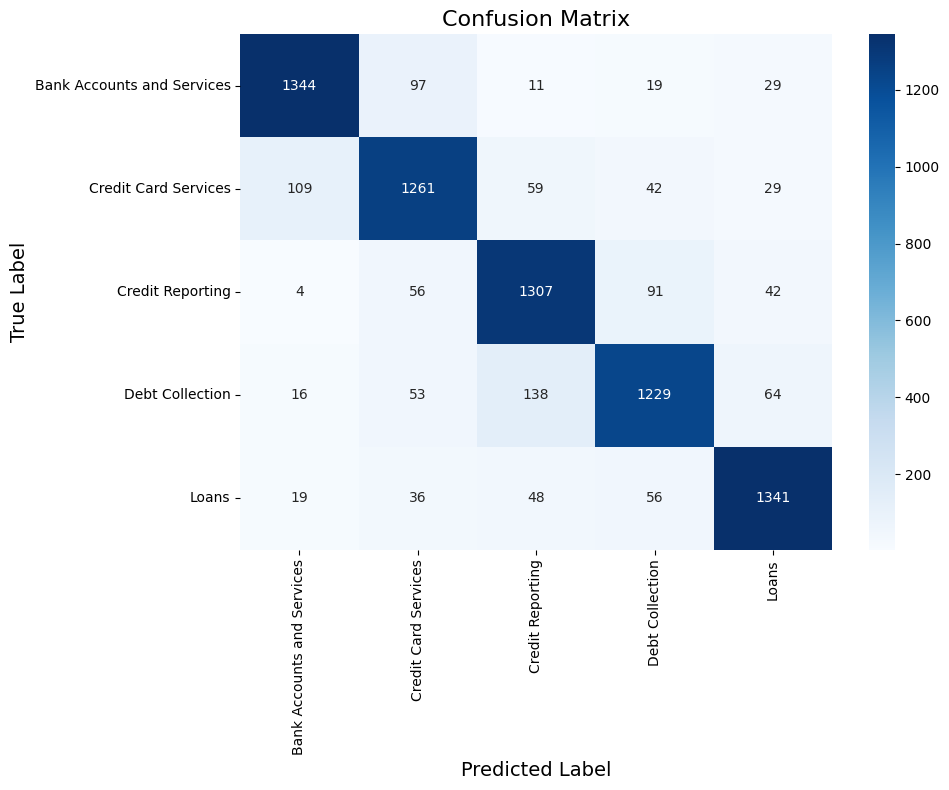

In [22]:
def evaluate_model(model, test_dataloader):
    model.eval()
    
    predictions = []
    true_labels = []
    
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass without gradient calculation
        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
        
        # Get predictions
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        
        # Store predictions and true labels
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions))
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'true_labels': true_labels,
        'predictions': predictions
    }

# Add missing import for confusion matrix
from sklearn.metrics import confusion_matrix

# Evaluate the model on the test set
test_results = evaluate_model(model, test_dataloader)

In [ ]:
def predict_complaint_category(text, model, tokenizer, label_mapping):
    # Tokenize the text
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    # Move inputs to the device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Forward pass without gradient calculation
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    # Get the predictions
    logits = outputs.logits
    prediction_id = torch.argmax(logits, dim=1).item()
    
    # Get the predicted category
    predicted_category = label_mapping[prediction_id]
    
    return predicted_category

# Example usage
example_text = "I am having issues with my credit card. The bank charged me an annual fee even though they said it would be waived."
predicted_category = predict_complaint_category(example_text, model, tokenizer, label_mapping)
print(f"Predicted category: {predicted_category}")

In [ ]:
# Example complaints
test_complaints = [
    "I am having issues with my credit card. The bank charged me an annual fee even though they said it would be waived.",
    "My credit report shows incorrect information. There are accounts listed that don't belong to me.",
    "I requested a loan modification three months ago, but I haven't heard anything back from the lender.",
    "A debt collector keeps calling me for a debt that isn't mine. I've told them multiple times it's not my debt.",
    "I cannot access my bank account online. The website keeps showing an error message."
]

# Predict categories
for i, complaint in enumerate(test_complaints):
    category = predict_complaint_category(complaint, model, tokenizer, label_mapping)
    print(f"Complaint {i+1}: {complaint[:50]}...")
    print(f"Predicted category: {category}\n")